# Começando a pensar no projeto

## BRAIN STORM

- Objetivo é lidar com um problema real, e tentar resolver ele usando: Classificação ou Regressão.
- Tente fazer uma análise bem abrangente, explicando cada etapa e justificando cada ação escolhida.
- Incluir gráficos e tabelas comparativas pode ajudar muito!

## BASE DE DADOS

**Faça escolha de um dataset da sua preferencia!**

Você pode procurar conjuntos de dados aqui:

1. No repositório da <a href="https://archive.ics.uci.edu/ml/datasets.php" target="_blank">UCI</a>.
1. No <a href="https://www.kaggle.com/datasets" target="_blank">Kaggle</a>.

## INICIANDO O PROJETO

**Carregando as bibliotecas**

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

**Carregando o conjunto de dados**

In [25]:
data = pd.read_csv('dados/CO2 Emissions_Canada.csv', sep=',')

rename_columns = {
    'Make': "make",
    'Model': "model",
    'Vehicle Class': "vehicle_class",
    'Engine Size(L)': "engine_size",
    'Cylinders': "cylinders",
    'Transmission': "transmission",
    'Fuel Type': "fuel_type",
    'Fuel Consumption City (L/100 km)': "fuel_cons_city",
    'Fuel Consumption Hwy (L/100 km)': "fuel_cons_hwy",
    'Fuel Consumption Comb (L/100 km)': "fuel_cons_comb",
    'Fuel Consumption Comb (mpg)': "fuel_cons_comb_mpg",
    'CO2 Emissions(g/km)': "co2",
}

data = data.rename(columns=rename_columns)

**Definindo o problema**

Aqui começa uma etapa de reflexão. Pense em um possivel problema que você poderia resolver usando os dados que tem disponíveis, por exemplo:

- Se escolhi um conjunto de dados com informações de vinhos e os preços deles, meu problema poderia ser tentar fazer a descobrir o preço de um vinho (que ainda não saiu no mercado) com base nas caracteristicas dele.

In [26]:
# detalhe aqui qual o problema que vai tentar resolver e explique por que seria um problema de classificação ou regressão ...

## ANÁLISE E EXPLORAÇÃO DOS DADOS

**Faça uma análise detalhada do conjunto de dados escolhidos.**

- Identifique os tipos de dados de cada coluna e caso seja necessário, faça uma conversão no tipo de dado. Em muitas situações é interessante renomear as colunas.
- Verifique se existem valores nulos, e caso existam, elabore uma estrategia para lidar com eles (apagar eles, substituir com outro valor, etc.).
- Faça uma análise estatistica dos dados para determinar aqueles que provavelmente não vão contribuir durante a modelagem (anomalías e outrliers).
- Pode aplicar escalonamento nos dados, para manter todos eles na mesma escala.
- Caso tenha features do tipo categorico e queria usar elas durante a modelagem, transforme elas para um valor numerico (encoding!).

**Identificando os tipos de dados**

In [27]:
data.dtypes

make                   object
model                  object
vehicle_class          object
engine_size           float64
cylinders               int64
transmission           object
fuel_type              object
fuel_cons_city        float64
fuel_cons_hwy         float64
fuel_cons_comb        float64
fuel_cons_comb_mpg      int64
co2                     int64
dtype: object

In [28]:
data.describe()

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,fuel_cons_comb_mpg,co2
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [29]:
# não existem valores nulos 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                7385 non-null   object 
 1   model               7385 non-null   object 
 2   vehicle_class       7385 non-null   object 
 3   engine_size         7385 non-null   float64
 4   cylinders           7385 non-null   int64  
 5   transmission        7385 non-null   object 
 6   fuel_type           7385 non-null   object 
 7   fuel_cons_city      7385 non-null   float64
 8   fuel_cons_hwy       7385 non-null   float64
 9   fuel_cons_comb      7385 non-null   float64
 10  fuel_cons_comb_mpg  7385 non-null   int64  
 11  co2                 7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 692.5+ KB


**Verificando dados não numéricos**

In [30]:
len(set(data.make))

42

In [31]:
len(set(data.model))

2053

In [32]:
data.vehicle_class.value_counts()

vehicle_class
SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   460
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: count, dtype: int64

In [33]:
data.transmission.value_counts()

transmission
AS6     1324
AS8     1211
M6       901
A6       789
A8       490
AM7      445
A9       339
AS7      319
AV       295
M5       193
AS10     168
AM6      132
AV7      118
AV6      113
M7        91
A5        84
AS9       77
A4        65
AM8       62
A7        53
AV8       39
A10       31
AS5       26
AV10      11
AM5        4
AM9        3
AS4        2
Name: count, dtype: int64

In [34]:
data.fuel_type.value_counts()

fuel_type
X    3637
Z    3202
E     370
D     175
N       1
Name: count, dtype: int64

**Verificando a correlação entre os dados numéricos**

Obs.: Exceto *fuel_cons_comb_mpg* que corresponde a feature *fuel_cons_comb* em outra unidade de medida.

In [35]:
data_numerical = data[['engine_size', 'cylinders', 'fuel_cons_city', 'fuel_cons_hwy', 'fuel_cons_comb', 'co2']]

In [36]:
corr_data = data_numerical.corr()

<AxesSubplot:>

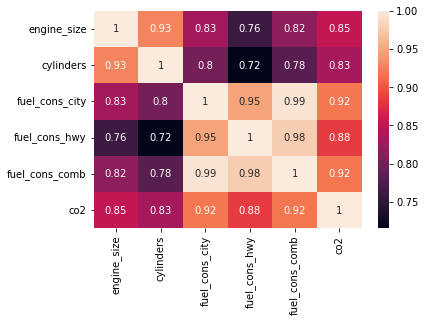

In [37]:
sns.heatmap(data=corr_data, annot=True)

**Removendo as features *fuel_cons_comb* e *fuel_cons_comb_mpg***

In [38]:
data.drop(columns=['fuel_cons_comb', 'fuel_cons_comb_mpg'], inplace=True)
data.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,244


**Análise do consumo de combustível na cidade x emissão de CO2 conforme o tipo de combustível**

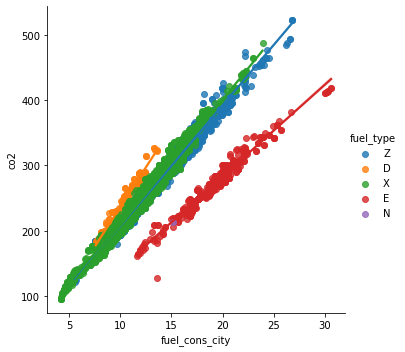

In [39]:
sns.lmplot(x='fuel_cons_city', y='co2', data=data, hue='fuel_type')

## MODELAGEM

#### 1. Importar a **classe do estimador que se deseja treinar** - escolher a hipótese!

- Identifique o problema com o qual está lidando (classificação ou regressão).
- Dependendo ao problema, faça escolha de qual estimador deseja usar para sua modelagem (pode escolher mais de uma para fins de teste!).

**Problema de Regressão** - Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

#### 2. Instanciar a classe do estimador, **escolhendo os hiperparâmetros desejados**
- Para a primeira versão do modelo, pode ser uma boa escolha utilizar os parâmetros default;
- Veremos mais pra frente como escolher os hiperparâmetros adequadamente;

In [41]:
random_forest = RandomForestRegressor(n_estimators=1000, max_features=0.3)

#### 3. Separe os dados em **dados de treino** e **dados de teste**.

In [42]:
data.columns

Index(['make', 'model', 'vehicle_class', 'engine_size', 'cylinders',
       'transmission', 'fuel_type', 'fuel_cons_city', 'fuel_cons_hwy', 'co2'],
      dtype='object')

In [43]:
data_numerical = data_numerical.drop(columns='fuel_cons_comb')
# Split data
X = data_numerical.drop(columns='co2')
y = data_numerical['co2']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
X_train

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy
6590,3.0,6,11.4,8.1
6274,4.0,6,14.7,10.3
2251,3.0,6,13.8,9.0
3149,3.4,6,11.3,7.9
4362,2.0,4,10.1,7.0
...,...,...,...,...
5191,2.0,4,10.3,7.4
5226,3.5,6,10.6,7.3
5390,3.5,6,11.7,8.8
860,2.5,4,9.5,7.4


#### 4. Treine o modelo, usando **os dados de treino**

In [45]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_features=0.3, n_estimators=1000)

#### 5. Use o modelo treinado para **fazer previsões** usando os **dados de teste** (ou **de validação**)

In [46]:
prediction = random_forest.predict(X_test)

#### 6. **Avalie a performance do modelo com base nas previsões acima**

Lembre que você pode treinar e avaliar muito modelos, e no final escolher aquele que teve melhor performance respeito à metrica escolhida.

**Erro médio absoluto**

In [47]:
mae = mean_absolute_error(y_test, prediction)
print(f'MAE: {mae}')

MAE: 2.9658401738405207


**Visualização gráfica dos valores reais x valores preditos**

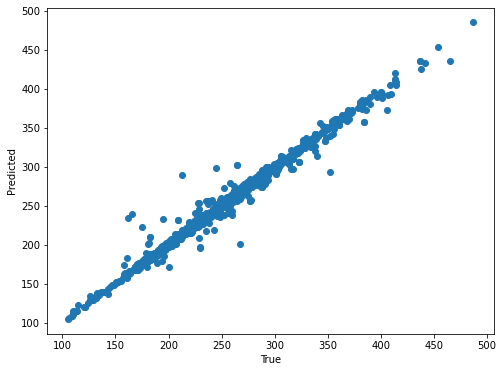

In [48]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axis.scatter(y_test, prediction)
axis.set_xlabel('True')
axis.set_ylabel('Predicted')


plt.show()

**Feature importance**

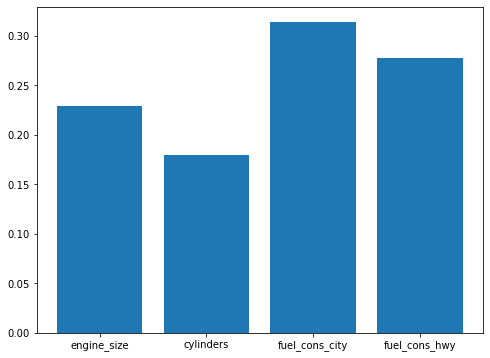

In [49]:
fig_bar, ax_bar = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
importance = random_forest.feature_importances_
var_names = X_train.columns.to_list()

ax_bar.bar(var_names, importance)
plt.show()